In [4]:
import os
import requests

from fashion_clip.fashion_clip import FashionCLIP, FCLIPDataset
from transformers import AutoFeatureExtractor, SegformerForSemanticSegmentation

import matplotlib.pyplot as plt
from PIL import Image

import torch.nn as nn
import torchvision.transforms as transforms

img = Image.open('C:/Users/Alex/Pictures/hank_jpg.jpg')

img_tensor = transforms.ToTensor()(img)#.unsqueeze(0)
print(img_tensor.shape)

fclip = FashionCLIP('fashion-clip')

image_embeddings_img = fclip.encode_images([img], 1)
image_embeddings_str = fclip.encode_images(['C:/Users/Alex/Pictures/alex_thumbnail.jpg'], 1)

image_embeddings = image_embeddings/np.linalg.norm(image_embeddings, ord=2, axis=-1, keepdims=True)
image_embeddings = image_embeddings/np.linalg.norm(image_embeddings, ord=2, axis=-1, keepdims=True)

print(image_embeddings_img.shape)
print(image_embeddings_str.shape)

torch.Size([3, 1000, 1000])


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.32it/s]

(1, 512)
(1, 512)


<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1000x1500 at 0x26F840141D0>
torch.Size([1500, 1000])
tensor([ 0,  2,  4,  6, 11, 15, 16])


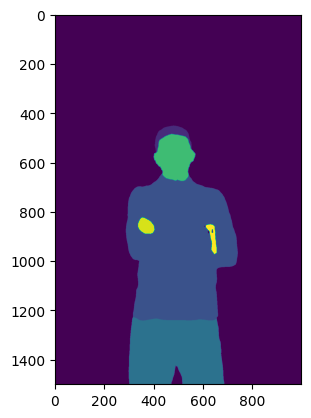

In [8]:


extractor = AutoFeatureExtractor.from_pretrained("mattmdjaga/segformer_b2_clothes")
model = SegformerForSemanticSegmentation.from_pretrained("mattmdjaga/segformer_b2_clothes")

url = "https://plus.unsplash.com/premium_photo-1673210886161-bfcc40f54d1f?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxzZWFyY2h8MXx8cGVyc29uJTIwc3RhbmRpbmd8ZW58MHx8MHx8&w=1000&q=80"

image = Image.open(requests.get(url, stream=True).raw)
print(image)
inputs = extractor(images=image, return_tensors="pt")

outputs = model(**inputs)
logits = outputs.logits.cpu()

upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

pred_seg = upsampled_logits.argmax(dim=1)[0]
print(pred_seg.shape)
print(pred_seg.unique())
plt.imshow(pred_seg)

In [15]:

old_map = {
   "Background": 0,
   "Bag": 16,
   "Belt": 8,
   "Dress": 7,
   "Face": 11,
   "Hair": 2,
   "Hat": 1,
   "Left-arm": 14,
   "Left-leg": 12,
   "Left-shoe": 9,
   "Pants": 6,
   "Right-arm": 15,
   "Right-leg": 13,
   "Right-shoe": 10,
   "Scarf": 17,
   "Skirt": 5,
   "Sunglasses": 3,
   "Upper-clothes": 4
} # we only need to process through some of these keys - and can merge shoes, etc?

key_map = {v: k for k, v in old_map.items()}


just loaded torch.Size([3, 1280, 960])
out of segmentation torch.Size([1500, 1000])
tensor([ 0,  2,  4,  6,  8, 11, 14, 15])
['Background', 'Hair', 'Upper-clothes', 'Pants', 'Belt', 'Face', 'Left-arm', 'Right-arm']


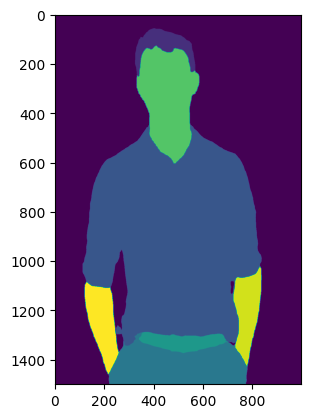

['Background', 'Upper-clothes', 'Pants', 'Belt']


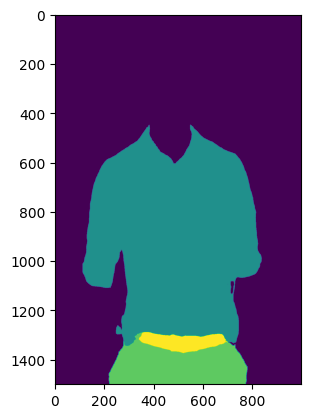

 torch.Size([3, 1500, 1000])
temp shape torch.Size([3, 1500, 1000])
mask shape torch.Size([1500, 1000])


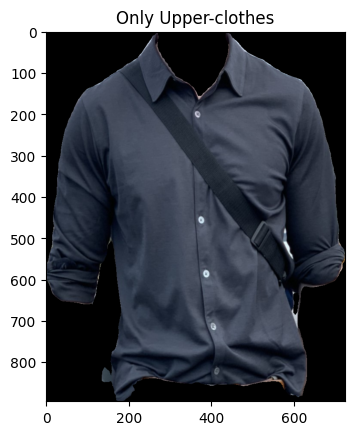

torch.Size([3, 895, 724])


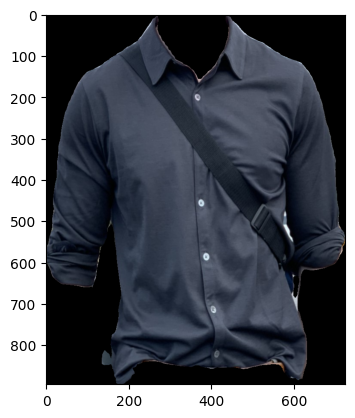

temp shape torch.Size([3, 1500, 1000])
mask shape torch.Size([1500, 1000])


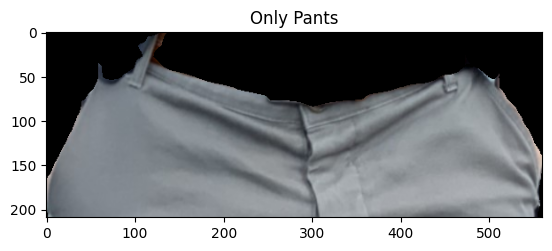

torch.Size([3, 209, 560])


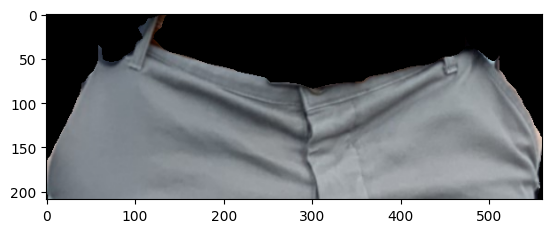

temp shape torch.Size([3, 1500, 1000])
mask shape torch.Size([1500, 1000])


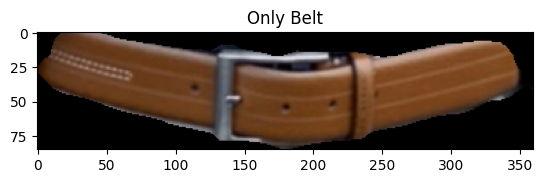

torch.Size([3, 85, 360])


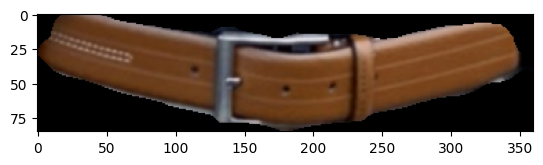

In [56]:

from torchvision.ops import masks_to_boxes
from torchvision.utils import draw_bounding_boxes
import torch

# Load an image
img = Image.open('C:/Users/Alex/Pictures/alex_thumbnail.jpg')
img_tensor = transforms.ToTensor()(img)
print('just loaded', img_tensor.shape)

# Segment image
inputs = extractor(images=img, return_tensors="pt")

with torch.no_grad(): outputs = model(**inputs)
logits = outputs.logits.cpu()

upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

mask = upsampled_logits.argmax(dim=1)[0]
print('out of segmentation', mask.shape)
print(mask.unique())
print([key_map[x] for x in mask.unique().tolist()])
plt.imshow(mask)
plt.show()

# Make the segmentation map relevant by removing unneeded features:
def relevant_map(mask):
    # make the mask relevant by merging features
    # let's just have this return a mask with only clothing
    
    mask[mask == 10] = 9 # Right shoes become left shoes
    
    # Remove then following:
    mask[mask == 11] = 0 # face
    mask[mask == 2] = 0 # hair
    mask[mask == 14] = 0 # left arm
    mask[mask == 12] = 0 # left leg
    mask[mask == 15] = 0 # right arm
    mask[mask == 13] = 0 # right leg
    return mask
    
mask = relevant_map(mask)
print([key_map[x] for x in mask.unique().tolist()])
plt.imshow(mask)
plt.show()
    
# Using segmentation map, great image into subimages
obj_ids = mask.unique()
masks = torch.BoolTensor(mask == obj_ids[:,None, None])
boxes = masks_to_boxes(masks)

subims = []
subids = []

resize = transforms.Resize((1500,1000))
to_image = transforms.ToPILImage()

image_tensor = resize(transforms.ToTensor()(img))
print('', image_tensor.shape)

for obind, obid in enumerate(obj_ids):
    if obid != 0:
        temp = image_tensor.clone()
        print('temp shape', temp.shape)
        print('mask shape', mask.shape)
        temp[:,mask!=obid] = 0 # Set everything but current clothing item to 0

        xmin = int(boxes[obind, 0])
        ymin = int(boxes[obind, 1])
        xmax =int(boxes[obind, 2])
        ymax = int(boxes[obind, 3])

        subim = temp[:, ymin:ymax, xmin:xmax]
        #subim = resize(subim)

        plt.imshow(subim.squeeze().permute(1,2,0))
        plt.title(f'Only {key_map[obid.item()]}')
        plt.show()
    
        print(subim.shape)
        subim = to_image(subim)
        plt.imshow(subim)
        plt.show()
        subims.append(subim) # I think we need them in image format for Clip
        subids.append(obid)



In [64]:
# We now have a list of item images. embed these
image_embeddings_batch = fclip.encode_images(subims, len(subims))
image_embeddings_batch = image_embeddings_batch/np.linalg.norm(image_embeddings_batch, ord=2, axis=-1, keepdims=True)

print(image_embeddings_batch.shape)



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.96it/s]

(3, 512)


In [65]:
print(dir(fclip))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slotnames__', '__str__', '__subclasshook__', '__weakref__', '_cosine_similarity', '_generate_vectors', '_get_heatmap', '_load_model', '_nearest_neighbours', 'approx', 'dataset', 'device', 'display_attention', 'encode_images', 'encode_text', 'model', 'model_hash', 'model_name', 'preprocess', 'retrieval', 'zero_shot_classification']


In [4]:
import bot_utils_2 as butils2
import bot_utils as butils
from PIL import Image


#utils.add_item_to_database(img = Image.open('C:/Users/Alex/Pictures/hank_jpg.jpg'), name = 'samplename', price = 99)
butils2.add_item_to_database(img = Image.open('C:/Users/Alex/Pictures/hank_jpg.jpg'))

output array shape in parse_image torch.Size([1, 3, 1024, 1024]) (1024, 1024)
[1 2] (1024, 1024)


NameError: name 'emb_centroid' is not defined

In [ ]:
output array shape in parse_image torch.Size([1, 3, 1024, 1024]) (1024, 1024)
[1 2] (1024, 1024)

In [ ]:
#
#
#
#
#
#
#
#
#
#
#
#
